In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from functools import partial
from itertools import product
from collections import defaultdict
import os, torch

os.makedirs('plots', exist_ok = True)

from load_data import load_rs_results, load_detailed_results

cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [20]:
mnist = load_rs_results('../results/mnist_rs')
mnist_detailed = load_detailed_results('../results/mnist_rs')

mnist_imb = load_rs_results('../results/mnist_imb')
mnist_imb_detailed = load_detailed_results('../results/mnist_imb')

cifar10 = load_rs_results('../results/cifar10_rs_mlp')
cifar10_detailed = load_detailed_results('../results/cifar10_rs_mlp')

cifar10_imb = load_rs_results('../results/cifar10_mlp_imb')
cifar10_imb_detailed = load_detailed_results('../results/cifar10_mlp_imb')


colors = dict(zip(sorted(mnist['group'].unique()), cs))

## Random search evaluation

In [3]:
def estimate_expected_quality_at_budget(budget, perfs, reps = 20): # TODO reps value?
    l = []
    for _ in range(reps):
        S = np.random.choice(perfs, size = budget, replace = True)
        l.append(S.max())
    return np.mean(l)

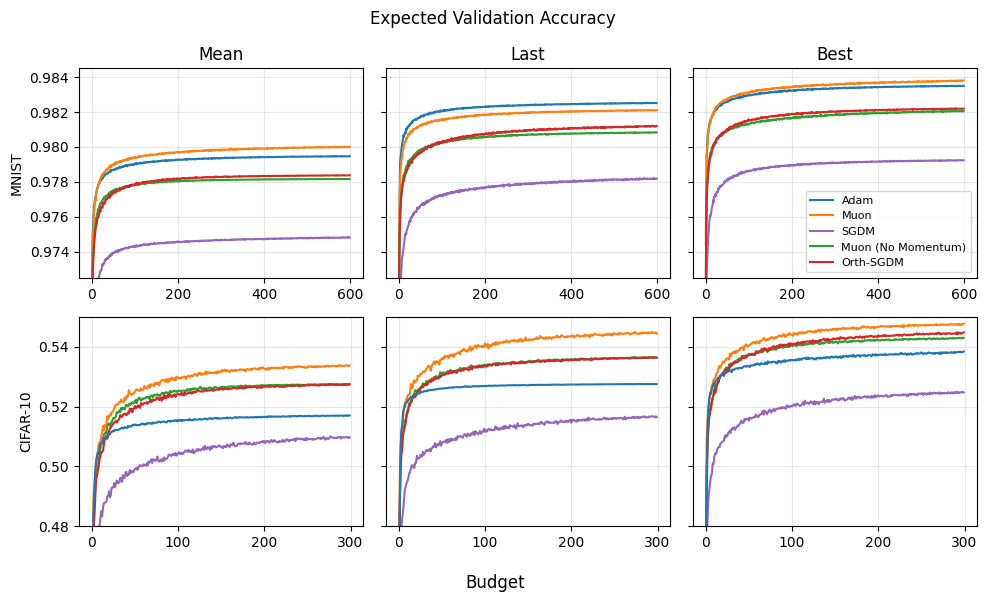

In [4]:
f, (axs) = plt.subplots(2, 3, figsize = (10, 6))

metric = 'best' # best, mean, last
ix = None
at = '-at-' + str(ix) if ix else ''

qs = {}


for df, ax_row, name in zip([mnist, cifar10], axs, ['MNIST', 'CIFAR-10']):
    for ax_i, (ax, metric) in enumerate(zip(ax_row, ['mean', 'last', 'best'])):
        for group in df['group'].unique():

            perfs = df.query('group==@group')[f'{metric}-val-acc' + at].to_numpy()

            if (name, metric, group) not in qs:
                qualities = []
                for budget in range(1, len(perfs) + 1):
                    qualities.append(estimate_expected_quality_at_budget(budget, perfs, reps = len(perfs)))

                qs[name,metric,group] = qualities
            else:
                qualities = qs[name,metric,group]

            if name == 'MNIST':
                ax.set_ylim(0.9725, 0.9845)
            else:
                ax.set_ylim(0.48, 0.55)

            if ax_i > 0: ax.set_yticklabels([])

            ax.plot(range(len(perfs)), qualities, label = group, color = colors[group])
            if df is mnist: ax.set_title(metric.title())
            ax.grid(alpha = 0.3)

axs[0, -1].legend(loc = 'lower right', fontsize = 8)
axs[0, 0].set_ylabel('MNIST')
axs[1, 0].set_ylabel('CIFAR-10')


f.suptitle(f'Expected Validation Accuracy {at.replace("-at-", "at epoch ").title()}')
f.supxlabel('Budget')
plt.tight_layout()
plt.savefig('plots/expected_perf_rs.png', dpi = 300)

## Stability

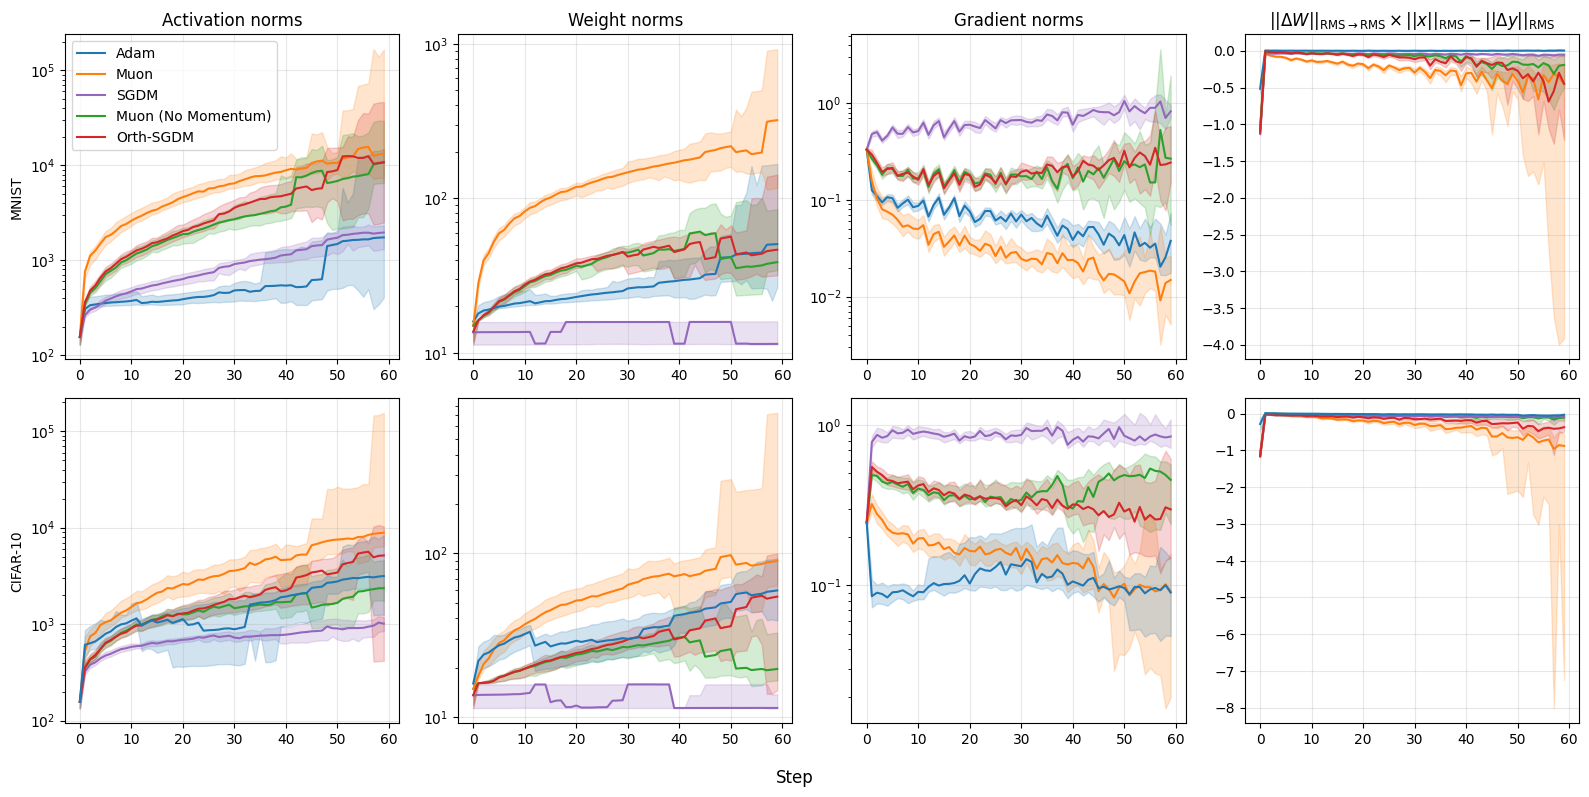

In [170]:
layers = sorted(list(set([c.split('/')[0] for c in mnist_detailed.columns if 'Linear' in c or 'Conv' in c])))
layer = layers[0]

cols = ['act-lF-norm', 'weight-lF-norm', 'grad-lF-norm', 'RMS-mean-dist-to-bound']
# cols = [f'{layer}/{c}' if '/' not in c else c for c in cols]
cols = [f'{layer}/{c}' for c in cols]

log = [True, True, True, False]

f, axs = plt.subplots(2, len(cols), figsize = (len(cols) * 4, 8))

for df, ax_row, name in zip([mnist_detailed, cifar10_detailed], axs, ['MNIST', 'CIFAR-10']):
    for ax, c, l in zip(ax_row, cols, log):

        # print(c)
        sns.lineplot(
            data = df, x = 'step', y = c, hue = 'group', palette = colors, estimator = 'median',
             ax = ax, legend = ax is axs[0, 0]#, errorbar = None if ax is ax_row[0] else ('ci', 0.95),
        )

        if l: ax.set_yscale('log')

        ax.set_ylabel(name if ax is ax_row[0] else '')
        ax.set_xlabel('')
        ax.grid(alpha = 0.3)

        # ax.set_title(c)

        # remove title from legend
        if ax is axs[0, 0]:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys())

axs[0, 0].set_title('Activation norms')
axs[0, 1].set_title('Weight norms')
axs[0, 2].set_title('Gradient norms')

axs[0, 3].set_title('$||\\Delta W||_{\\text{RMS} \\to \\text{RMS}} \\times ||x||_\\text{RMS} - ||\\Delta y||_\\text{RMS}$')
# axs[0, -1].set_ylim(-0.2, 0)
# axs[1, -1].set_ylim(-0.2, 0)

f.supxlabel('Step')
f.tight_layout()

plt.savefig('plots/stability.png', dpi = 300)

## Effects on gradient

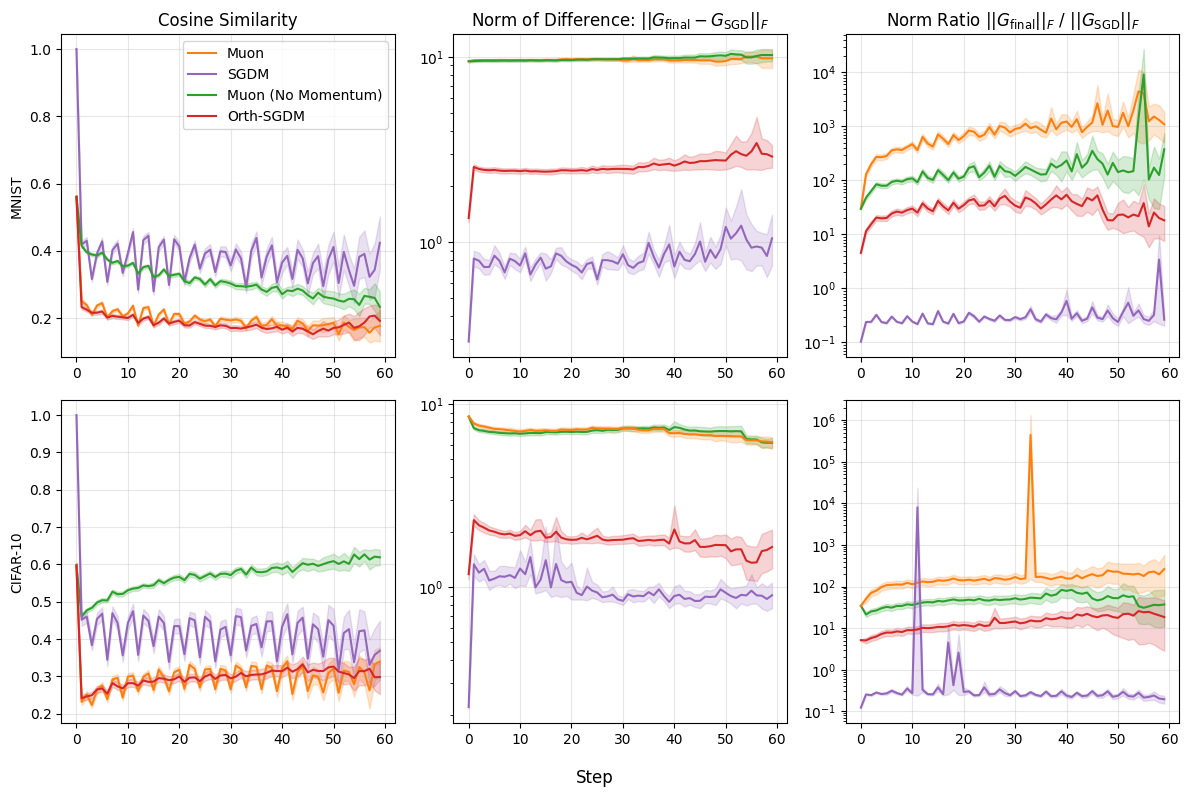

In [184]:
layers = sorted(list(set([c.split('/')[0] for c in mnist_detailed.columns if 'Linear' in c or 'Conv' in c])))
layer = layers[0]

cols = ['weight-overall-grad-cos-sim', 'weight-overall-grad-lF-diff', 'weight-overall-grad-norm-ratio']
cols = [f'{layer}/{c}' for c in cols]


f, axs = plt.subplots(2, len(cols), figsize = (len(cols) * 4, 8))

for df, ax_row, name in zip([mnist_detailed, cifar10_detailed], axs, ['MNIST', 'CIFAR-10']):
    for ax, c in zip(ax_row, cols):

        sns.lineplot(data = df, x = 'step', y = c, hue = 'group', palette = colors, ax = ax, legend = ax is axs[0, 0], estimator='mean')
        if 'cos' not in c: ax.set_yscale('log')

        ax.set_ylabel(name if ax is ax_row[0] else '')
        ax.set_xlabel('')
        ax.grid(alpha = 0.3)

        # remove title from legend and exclude 'Adam' label
        if ax is axs[0, 0]:
            handles, labels = ax.get_legend_handles_labels()
            by_label = {label: handle for label, handle in zip(labels, handles) if label != 'Adam'}
            ax.legend(by_label.values(), by_label.keys())

axs[0, 0].set_title('Cosine Similarity')
axs[0, 1].set_title('Norm of Difference: $||G_\\text{final} - G_\\text{SGD}||_F$')
axs[0, 2].set_title('Norm Ratio $||G_\\text{final}||_F \\ / \\ ||G_\\text{SGD}||_F$')

f.supxlabel('Step')

# f.suptitle('Effects on SGD gradients Gradient before and after update?')
f.tight_layout()
plt.savefig('plots/grad_before_after.png', dpi = 300)

## Imbalanced data

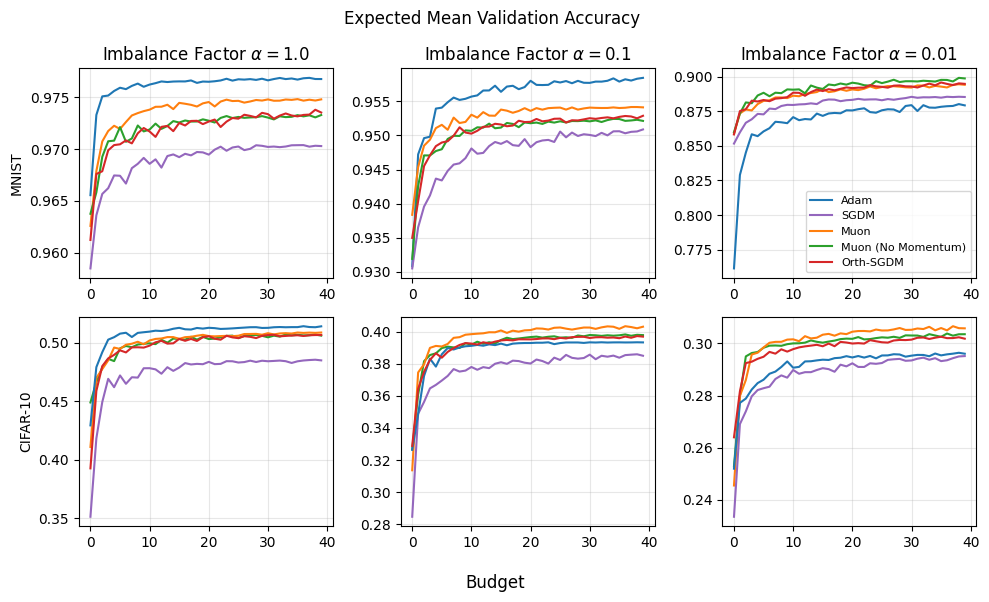

In [183]:
f, (axs) = plt.subplots(2, 3, figsize = (10, 6))

metric = 'mean' # best, mean, last
ix = None
at = '-at-' + str(ix) if ix else ''

qs = {}

factors = sorted(mnist_imb['imb_factor'].unique().tolist(), reverse = True)

for df, ax_row, name in zip([mnist_imb, cifar10_imb], axs, ['MNIST', 'CIFAR-10']):
    for ax_i, (ax, factor) in enumerate(zip(ax_row, factors)):
        for group in df['group'].unique():

            perfs = df.query('group==@group and imb_factor==@factor')[f'{metric}-val-acc' + at].to_numpy()

            qualities = []
            for budget in range(1, len(perfs) + 1):
                qualities.append(estimate_expected_quality_at_budget(budget, perfs, reps = len(perfs)))

            ax.plot(range(len(perfs)), qualities, label = group, color = colors[group])
            if df is mnist_imb: ax.set_title(f'Imbalance Factor $\\alpha = {factor}$')
            ax.grid(alpha = 0.3)

axs[0, -1].legend(loc = 'lower right', fontsize = 8)
axs[0, 0].set_ylabel('MNIST')
axs[1, 0].set_ylabel('CIFAR-10')


f.suptitle(f'Expected Mean Validation Accuracy {at.replace("-at-", "at epoch ").title()}')
f.supxlabel('Budget')
plt.tight_layout()
plt.savefig('plots/expected_perf_imb.png', dpi = 300)